***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-2.3)** From coarse-to-Fine slowly decrease the dimension. i.e. 32D>16D>8D (Coarse>Medium>FINE), While keeping the primary capsule dimension same as original ($P_{capsule} = 8D$). Training without $L_{cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD_2\Training_and_Analysis\3_CIFAR-10
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "2" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  2
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('MOD_2/3_CIFAR_10/HD_CapsNet/TD_WO_C_loss')

FOLDER CREATED =  ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/TD_WO_C_loss


# Import Dataset : CIFAR-10

In [5]:
dataset = datasets.CIFAR10(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR10(version = 'reduce') # importing CIFAR10 Dataset

CIFAR-10 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")
    return total_marginloss

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*margin_loss(y_true_m, y_pred_m)
    ML_f = LW_F*margin_loss(y_true_f, y_pred_f)
    batch_loss = ML_c + ML_m+ ML_f
    return tf.reduce_mean(batch_loss)

## Model Architecture

In [10]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = 2
    no_medium_class = 7
    no_fine_class = 10

    PCap_n_dims = 8

    SCap_f_dims = 8
    SCap_m_dims = 16
    SCap_c_dims = 32


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims),
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_c)
    
    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')
    
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [11]:
model = get_compiled_model()

In [12]:
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.math.subtract_3 (TFOpLambda  (None, 7)           0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.subtract_4 (TFOpLambda  (None, 7)           0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.maximum (TFOpLambda)   (None, 2)            0           ['tf.math.subtract[0][0]']       
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 2)           0           ['input_yc[0][0]']               
 )        

 da)                                                                                              
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 10)           0           ['tf.math.multiply_8[0][0]',     
                                                                  'tf.math.multiply_10[0][0]']    
                                                                                                  
 tf.math.multiply_3 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum[0][0]']     
 )                                                                                                
                                                                                                  
 tf.math.multiply_7 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum_1[0][0]']   
 )                                                                                                
          

## Data Augmentation

In [13]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [14]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [15]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.3409 - prediction_coarse_accuracy: 0.8352 - prediction_medium_accuracy: 0.3779 - prediction_fine_accuracy: 0.2140
  • Coarse Accuracy = 83.52% | Val_Accuracy = 84.89% | LossWeight = 0.16 
  • Medium Accuracy = 37.79% | Val_Accuracy = 47.56% | LossWeight = 0.43 
  • Fine   Accuracy = 21.40% | Val_Accuracy = 31.50% | LossWeight = 0.41 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.31500, saving model to ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/TD_WO_C_loss\epoch-best.h5
781/781 [==============================] - 65s 70ms/step - loss: 0.3409 - prediction_coarse_accuracy: 0.8352 - prediction_medium_accuracy: 0.3779 - prediction_fine_accuracy: 0.2140 - val_loss: 0.2686 - val_prediction_coarse_accuracy: 0.8489 - val_prediction_medium_accuracy: 0.4756 - val_prediction_fine_accuracy: 0.3150 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.2331 - prediction_coarse_accurac

781/781 [==============================] - 40s 52ms/step - loss: 0.1392 - prediction_coarse_accuracy: 0.9317 - prediction_medium_accuracy: 0.7703 - prediction_fine_accuracy: 0.6667 - val_loss: 0.1029 - val_prediction_coarse_accuracy: 0.9566 - val_prediction_medium_accuracy: 0.7896 - val_prediction_fine_accuracy: 0.7040 - lr: 0.0010
Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.1319 - prediction_coarse_accuracy: 0.9377 - prediction_medium_accuracy: 0.7873 - prediction_fine_accuracy: 0.6932
  • Coarse Accuracy = 93.77% | Val_Accuracy = 94.82% | LossWeight = 0.17 
  • Medium Accuracy = 78.73% | Val_Accuracy = 78.69% | LossWeight = 0.40 
  • Fine   Accuracy = 69.32% | Val_Accuracy = 69.00% | LossWeight = 0.43 

Epoch 10: val_prediction_fine_accuracy did not improve from 0.70400
781/781 [==============================] - 40s 52ms/step - loss: 0.1319 - prediction_coarse_accuracy: 0.9377 - prediction_medium_accuracy: 0.7873 - prediction_fine_accuracy: 0.6932 - val_

781/781 [==============================] - 42s 54ms/step - loss: 0.0941 - prediction_coarse_accuracy: 0.9616 - prediction_medium_accuracy: 0.8753 - prediction_fine_accuracy: 0.8193 - val_loss: 0.0663 - val_prediction_coarse_accuracy: 0.9737 - val_prediction_medium_accuracy: 0.8668 - val_prediction_fine_accuracy: 0.8208 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.0910 - prediction_coarse_accuracy: 0.9646 - prediction_medium_accuracy: 0.8823 - prediction_fine_accuracy: 0.8305
  • Coarse Accuracy = 96.46% | Val_Accuracy = 96.75% | LossWeight = 0.17 
  • Medium Accuracy = 88.23% | Val_Accuracy = 86.80% | LossWeight = 0.40 
  • Fine   Accuracy = 83.05% | Val_Accuracy = 82.34% | LossWeight = 0.43 

Epoch 19: val_prediction_fine_accuracy improved from 0.82270 to 0.82340, saving model to ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/TD_WO_C_loss\epoch-best.h5
781/781 [==============================] - 43s 55ms/step - loss: 0.0910 - prediction_coarse_accu

781/781 [==============================] - 42s 54ms/step - loss: 0.0761 - prediction_coarse_accuracy: 0.9736 - prediction_medium_accuracy: 0.9190 - prediction_fine_accuracy: 0.8798 - val_loss: 0.0542 - val_prediction_coarse_accuracy: 0.9780 - val_prediction_medium_accuracy: 0.8925 - val_prediction_fine_accuracy: 0.8524 - lr: 4.1812e-04
Epoch 28/100
780/781 [============================>.] - ETA: 0s - loss: 0.0745 - prediction_coarse_accuracy: 0.9740 - prediction_medium_accuracy: 0.9221 - prediction_fine_accuracy: 0.8833
  • Coarse Accuracy = 97.40% | Val_Accuracy = 97.88% | LossWeight = 0.18 
  • Medium Accuracy = 92.21% | Val_Accuracy = 89.69% | LossWeight = 0.39 
  • Fine   Accuracy = 88.33% | Val_Accuracy = 85.44% | LossWeight = 0.43 

Epoch 28: val_prediction_fine_accuracy improved from 0.85240 to 0.85440, saving model to ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/TD_WO_C_loss\epoch-best.h5
781/781 [==============================] - 40s 51ms/step - loss: 0.0745 - prediction_coarse_accu

781/781 [==============================] - 40s 51ms/step - loss: 0.0670 - prediction_coarse_accuracy: 0.9788 - prediction_medium_accuracy: 0.9396 - prediction_fine_accuracy: 0.9130 - val_loss: 0.0506 - val_prediction_coarse_accuracy: 0.9808 - val_prediction_medium_accuracy: 0.9011 - val_prediction_fine_accuracy: 0.8641 - lr: 2.6352e-04
Epoch 37/100
781/781 [==============================] - ETA: 0s - loss: 0.0677 - prediction_coarse_accuracy: 0.9777 - prediction_medium_accuracy: 0.9390 - prediction_fine_accuracy: 0.9108
  • Coarse Accuracy = 97.77% | Val_Accuracy = 98.10% | LossWeight = 0.20 
  • Medium Accuracy = 93.90% | Val_Accuracy = 90.05% | LossWeight = 0.38 
  • Fine   Accuracy = 91.08% | Val_Accuracy = 86.36% | LossWeight = 0.42 

Epoch 37: val_prediction_fine_accuracy did not improve from 0.86410
781/781 [==============================] - 40s 51ms/step - loss: 0.0677 - prediction_coarse_accuracy: 0.9777 - prediction_medium_accuracy: 0.9390 - prediction_fine_accuracy: 0.9108 - 

Epoch 46/100
781/781 [==============================] - ETA: 0s - loss: 0.0642 - prediction_coarse_accuracy: 0.9801 - prediction_medium_accuracy: 0.9488 - prediction_fine_accuracy: 0.9275
  • Coarse Accuracy = 98.01% | Val_Accuracy = 98.07% | LossWeight = 0.21 
  • Medium Accuracy = 94.88% | Val_Accuracy = 90.59% | LossWeight = 0.38 
  • Fine   Accuracy = 92.75% | Val_Accuracy = 86.95% | LossWeight = 0.41 

Epoch 46: val_prediction_fine_accuracy did not improve from 0.86950
781/781 [==============================] - 39s 50ms/step - loss: 0.0642 - prediction_coarse_accuracy: 0.9801 - prediction_medium_accuracy: 0.9488 - prediction_fine_accuracy: 0.9275 - val_loss: 0.0485 - val_prediction_coarse_accuracy: 0.9807 - val_prediction_medium_accuracy: 0.9059 - val_prediction_fine_accuracy: 0.8695 - lr: 1.5778e-04
Epoch 47/100
781/781 [==============================] - ETA: 0s - loss: 0.0630 - prediction_coarse_accuracy: 0.9807 - prediction_medium_accuracy: 0.9499 - prediction_fine_accuracy: 0.

781/781 [==============================] - ETA: 0s - loss: 0.0608 - prediction_coarse_accuracy: 0.9812 - prediction_medium_accuracy: 0.9528 - prediction_fine_accuracy: 0.9353
  • Coarse Accuracy = 98.12% | Val_Accuracy = 98.22% | LossWeight = 0.22 
  • Medium Accuracy = 95.28% | Val_Accuracy = 90.86% | LossWeight = 0.39 
  • Fine   Accuracy = 93.53% | Val_Accuracy = 87.31% | LossWeight = 0.40 

Epoch 55: val_prediction_fine_accuracy improved from 0.87220 to 0.87310, saving model to ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/TD_WO_C_loss\epoch-best.h5
781/781 [==============================] - 40s 51ms/step - loss: 0.0608 - prediction_coarse_accuracy: 0.9812 - prediction_medium_accuracy: 0.9528 - prediction_fine_accuracy: 0.9353 - val_loss: 0.0469 - val_prediction_coarse_accuracy: 0.9822 - val_prediction_medium_accuracy: 0.9086 - val_prediction_fine_accuracy: 0.8731 - lr: 9.9440e-05
Epoch 56/100
780/781 [============================>.] - ETA: 0s - loss: 0.0613 - prediction_coarse_accuracy: 

781/781 [==============================] - 73s 94ms/step - loss: 0.0603 - prediction_coarse_accuracy: 0.9820 - prediction_medium_accuracy: 0.9557 - prediction_fine_accuracy: 0.9404 - val_loss: 0.0460 - val_prediction_coarse_accuracy: 0.9829 - val_prediction_medium_accuracy: 0.9129 - val_prediction_fine_accuracy: 0.8748 - lr: 6.2672e-05
Epoch 65/100
781/781 [==============================] - ETA: 0s - loss: 0.0600 - prediction_coarse_accuracy: 0.9822 - prediction_medium_accuracy: 0.9556 - prediction_fine_accuracy: 0.9401
  • Coarse Accuracy = 98.22% | Val_Accuracy = 98.21% | LossWeight = 0.22 
  • Medium Accuracy = 95.56% | Val_Accuracy = 91.02% | LossWeight = 0.39 
  • Fine   Accuracy = 94.01% | Val_Accuracy = 87.37% | LossWeight = 0.39 

Epoch 65: val_prediction_fine_accuracy did not improve from 0.87480
781/781 [==============================] - 71s 91ms/step - loss: 0.0600 - prediction_coarse_accuracy: 0.9822 - prediction_medium_accuracy: 0.9556 - prediction_fine_accuracy: 0.9401 - 

Epoch 74/100
781/781 [==============================] - ETA: 0s - loss: 0.0597 - prediction_coarse_accuracy: 0.9817 - prediction_medium_accuracy: 0.9556 - prediction_fine_accuracy: 0.9421
  • Coarse Accuracy = 98.17% | Val_Accuracy = 98.32% | LossWeight = 0.23 
  • Medium Accuracy = 95.56% | Val_Accuracy = 91.20% | LossWeight = 0.39 
  • Fine   Accuracy = 94.21% | Val_Accuracy = 87.56% | LossWeight = 0.38 

Epoch 74: val_prediction_fine_accuracy did not improve from 0.87670
781/781 [==============================] - 73s 93ms/step - loss: 0.0597 - prediction_coarse_accuracy: 0.9817 - prediction_medium_accuracy: 0.9556 - prediction_fine_accuracy: 0.9421 - val_loss: 0.0455 - val_prediction_coarse_accuracy: 0.9832 - val_prediction_medium_accuracy: 0.9120 - val_prediction_fine_accuracy: 0.8756 - lr: 3.7524e-05
Epoch 75/100
781/781 [==============================] - ETA: 0s - loss: 0.0603 - prediction_coarse_accuracy: 0.9826 - prediction_medium_accuracy: 0.9571 - prediction_fine_accuracy: 0.

781/781 [==============================] - 68s 87ms/step - loss: 0.0602 - prediction_coarse_accuracy: 0.9826 - prediction_medium_accuracy: 0.9567 - prediction_fine_accuracy: 0.9432 - val_loss: 0.0457 - val_prediction_coarse_accuracy: 0.9830 - val_prediction_medium_accuracy: 0.9130 - val_prediction_fine_accuracy: 0.8738 - lr: 2.3650e-05
Epoch 84/100
781/781 [==============================] - ETA: 0s - loss: 0.0591 - prediction_coarse_accuracy: 0.9821 - prediction_medium_accuracy: 0.9571 - prediction_fine_accuracy: 0.9430
  • Coarse Accuracy = 98.21% | Val_Accuracy = 98.38% | LossWeight = 0.23 
  • Medium Accuracy = 95.71% | Val_Accuracy = 91.23% | LossWeight = 0.39 
  • Fine   Accuracy = 94.30% | Val_Accuracy = 87.61% | LossWeight = 0.38 

Epoch 84: val_prediction_fine_accuracy did not improve from 0.87700
781/781 [==============================] - 74s 95ms/step - loss: 0.0591 - prediction_coarse_accuracy: 0.9821 - prediction_medium_accuracy: 0.9571 - prediction_fine_accuracy: 0.9430 - 

781/781 [==============================] - ETA: 0s - loss: 0.0602 - prediction_coarse_accuracy: 0.9821 - prediction_medium_accuracy: 0.9561 - prediction_fine_accuracy: 0.9421
  • Coarse Accuracy = 98.21% | Val_Accuracy = 98.32% | LossWeight = 0.23 
  • Medium Accuracy = 95.61% | Val_Accuracy = 91.14% | LossWeight = 0.39 
  • Fine   Accuracy = 94.21% | Val_Accuracy = 87.60% | LossWeight = 0.39 

Epoch 93: val_prediction_fine_accuracy did not improve from 0.87700
781/781 [==============================] - 53s 67ms/step - loss: 0.0602 - prediction_coarse_accuracy: 0.9821 - prediction_medium_accuracy: 0.9561 - prediction_fine_accuracy: 0.9421 - val_loss: 0.0460 - val_prediction_coarse_accuracy: 0.9832 - val_prediction_medium_accuracy: 0.9114 - val_prediction_fine_accuracy: 0.8760 - lr: 1.4160e-05
Epoch 94/100
781/781 [==============================] - ETA: 0s - loss: 0.0593 - prediction_coarse_accuracy: 0.9817 - prediction_medium_accuracy: 0.9566 - prediction_fine_accuracy: 0.9438
  • Coar

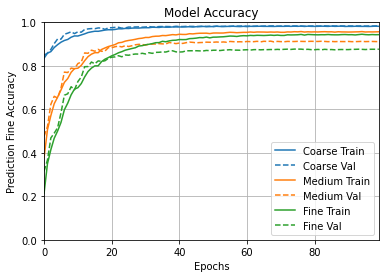

In [16]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

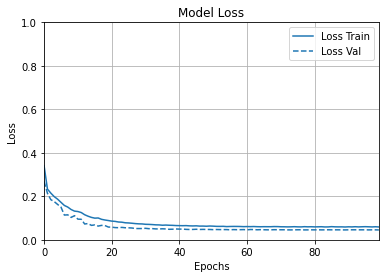

In [17]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

## Model Analysis

In [18]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 9s 20ms/step - loss: 0.0633 - prediction_coarse_loss: 0.0149 - prediction_medium_loss: 0.0641 - prediction_fine_loss: 0.0919 - prediction_coarse_accuracy: 0.9833 - prediction_medium_accuracy: 0.9113 - prediction_fine_accuracy: 0.8765
1. loss ==> 0.06330516934394836
2. prediction_coarse_loss ==> 0.014934303238987923
3. prediction_medium_loss ==> 0.06408677995204926
4. prediction_fine_loss ==> 0.09191752970218658
5. prediction_coarse_accuracy ==> 0.983299970626831
6. prediction_medium_accuracy ==> 0.911300003528595
7. prediction_fine_accuracy ==> 0.8765000104904175
313/313 [==============================] - 5s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

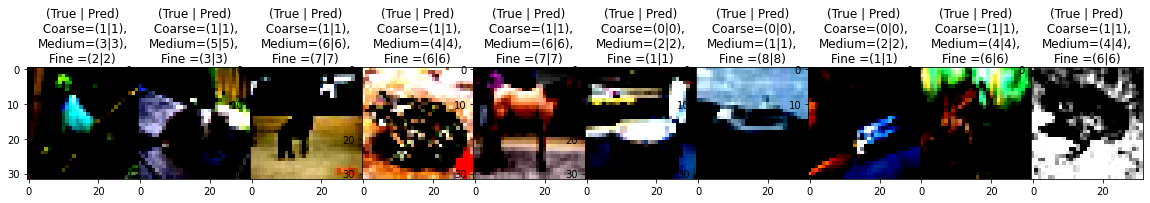

In [19]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[3924   76]
 [  91 5909]]

  • MEDIUM LEVEL 
[[ 913   22   24   21    3   11    6]
 [  37  923   27    6    2    4    1]
 [  11   15 1960    5    3    4    2]
 [  35    4    3  814   39   59   46]
 [   8    1    4   14  933   32    8]
 [  12    7   18   55   53 1756   99]
 [  12    4    9   45   33   83 1814]]

  • FINE LEVEL 
[[917  10  21   8   3   2   3   2  22  12]
 [  6 944   1   0   1   0   1   0   8  39]
 [ 35   3 819  32  26  24  39  18   4   0]
 [ 11   3  39 747  26 104  39  20   4   7]
 [  9   1  39  28 846  12  37  24   3   1]
 [  2   1  21 115  24 785  18  24   3   7]
 [  7   2  15  29   5   3 935   2   1   1]
 [  6   0  10  14  20  24   3 916   1   6]
 [ 38  14   6   3   0   1   2   1 923  12]
 [  5  41   4   3   0   1   2   1  10 933]]

  • Classification Report 


  • COARSE LEVEL 


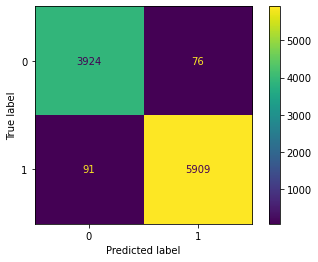

              precision    recall  f1-score   support

           0    0.97733   0.98100   0.97916      4000
           1    0.98730   0.98483   0.98607      6000

    accuracy                        0.98330     10000
   macro avg    0.98232   0.98292   0.98261     10000
weighted avg    0.98331   0.98330   0.98331     10000


  • MEDIUM LEVEL 


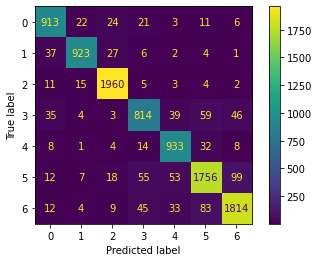

              precision    recall  f1-score   support

           0    0.88813   0.91300   0.90039      1000
           1    0.94570   0.92300   0.93421      1000
           2    0.95844   0.98000   0.96910      2000
           3    0.84792   0.81400   0.83061      1000
           4    0.87523   0.93300   0.90319      1000
           5    0.90097   0.87800   0.88934      2000
           6    0.91802   0.90700   0.91247      2000

    accuracy                        0.91130     10000
   macro avg    0.90492   0.90686   0.90562     10000
weighted avg    0.91118   0.91130   0.91102     10000


  • FINE LEVEL 


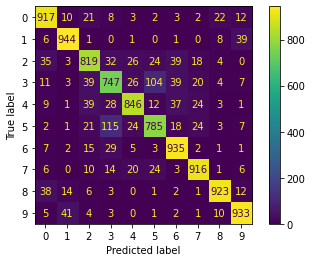

              precision    recall  f1-score   support

           0    0.88514   0.91700   0.90079      1000
           1    0.92640   0.94400   0.93512      1000
           2    0.84000   0.81900   0.82937      1000
           3    0.76302   0.74700   0.75493      1000
           4    0.88959   0.84600   0.86725      1000
           5    0.82113   0.78500   0.80266      1000
           6    0.86654   0.93500   0.89947      1000
           7    0.90873   0.91600   0.91235      1000
           8    0.94280   0.92300   0.93279      1000
           9    0.91650   0.93300   0.92468      1000

    accuracy                        0.87650     10000
   macro avg    0.87599   0.87650   0.87594     10000
weighted avg    0.87599   0.87650   0.87594     10000



In [20]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [21]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.9232116666666667 
Hierarchical Recall = 0.9253666666666668 
Hierarchical F1-Score = 0.9241166666666668 
Consistency =  0.9875 
Exact Match =  0.8725
